In [1]:
import numpy as np
import astropy.units as u
import sbpy.activity as sba
import matplotlib.pyplot as plt
from sbpy.data import Phys

# Applying the vectorial model included in sbpy.activity

The vectorial model implemented here is described in [Festou 1981](https://ui.adsabs.harvard.edu/abs/1981A%26A....95...69F) and incorporated as a derived class of GasComa in [`sbpy.activity.gas`]() that serves as an alternative to the Haser model ([Haser 1957](https://ui.adsabs.harvard.edu/abs/1957BSRSL..43..740H/abstract), [Haser 2020](https://iopscience.iop.org/article/10.3847/PSJ/abc17b/meta)).

### Putting together the necessary input parameters and running the model

In [2]:
# Rough parameters for a quick example calculation

# Parent molecule is H2O
parent_species = Phys.from_dict({
    # Total lifetime: will be smaller due to other sources of destruction, but this multiplicative
    # factor is approximate
    'tau_T': sba.photo_timescale('H2O') * 0.8,
    # Dissociative lifetime
    'tau_d': sba.photo_timescale('H2O'),
    # Outgoing velocity, taken from Cochran and Schleicher, 1993
    'v': 0.85 * u.km/u.s,
    # Cross section
    'sigma': 3e-16 * u.cm**2
    })

# Fragment is OH
fragment_species = Phys.from_dict({
    # Total lifetime: Again, factor of 0.8 is approximate
    'tau_T': sba.photo_timescale('OH') * 0.8,
    # Velocity after dissociation, taken from Cochran and Schleicher, 1993
    'v': 1.05 * u.km/u.s
    })

# 30 days ago to 15 days ago, production was 1e28/s,
# then jumped to 3e28/s from 15 days ago to now
times_at_production = [30, 15] * u.day
production_rates = [1.e28, 3.e28] * (1/u.s)


# Call the model
coma = sba.VectorialModel(Q=production_rates, dt=times_at_production, parent=parent_species, fragment=fragment_species)

### Examining the results for volume density with plots, both on-grid and interpolated

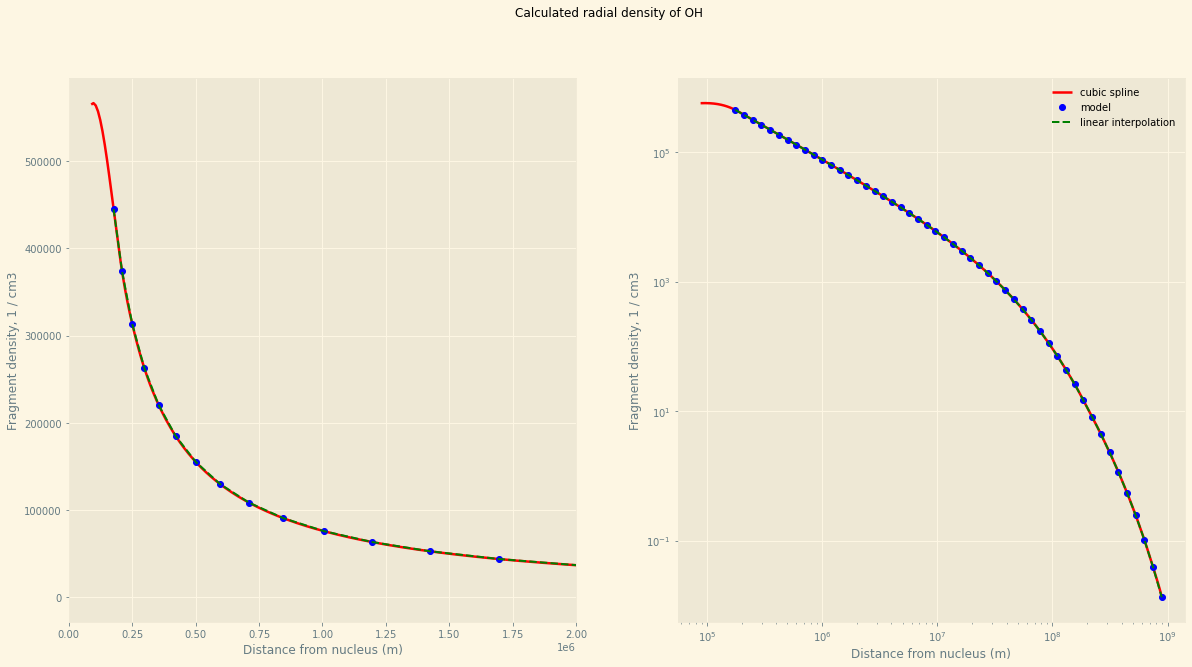

In [3]:
fragName = "OH"
volUnits = 1/(u.cm**3)
xMin_logplot = coma.vModel['CollisionSphereRadius'].to('m').value
xMax_logplot = coma.vModel['MaxRadiusOfGrid'].to('m').value
# Both in meters
xMin_linear = 0
xMax_linear = 2000000

# 100km intervals for x axis
interpArrayX = np.linspace(xMin_logplot, xMax_logplot, 100000)
# Interpolator spits out m^-3
interpArrayY = (coma.vModel['rDensInterpolator'](interpArrayX)/(u.m**3)).to(volUnits).value

plt.style.use('Solarize_Light2')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set(xlabel='Distance from nucleus (m)')
ax1.set(ylabel=f"Fragment density, {volUnits.unit.to_string()}")
ax2.set(xlabel='Distance from nucleus (m)')
ax2.set(ylabel=f"Fragment density, {volUnits.unit.to_string()}")
fig.suptitle(f"Calculated radial density of {fragName}")

ax1.set_xlim([xMin_linear, xMax_linear])
ax1.plot(interpArrayX, interpArrayY, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
ax1.plot(coma.vModel['FastRadialGrid'], coma.vModel['RadialDensity'].to(volUnits), 'bo', label="model")
ax1.plot(coma.vModel['FastRadialGrid'], coma.vModel['RadialDensity'].to(volUnits), 'g--', label="linear interpolation")

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.loglog(interpArrayX, interpArrayY, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
ax2.loglog(coma.vModel['FastRadialGrid'], coma.vModel['RadialDensity'].to(volUnits), 'bo', label="model")
ax2.loglog(coma.vModel['FastRadialGrid'], coma.vModel['RadialDensity'].to(volUnits), 'g--', label="linear interpolation")

plt.legend(loc='upper right', frameon=False)
plt.show()


### Examining the results for volume density by printing out the model's grid data

In [4]:
print("\n\nRadius (km) vs Fragment density (1/cm3)\n---------------------------------------")
vds = list(zip(coma.vModel['RadialGrid'], coma.vModel['RadialDensity']))
for pair in vds:
    print(f'{pair[0].to(u.km):7.0f} :\t{pair[1].to(1/(u.cm**3)):5.3e}')



Radius (km) vs Fragment density (1/cm3)
---------------------------------------
    176 km :	4.452e+05 1 / cm3
    210 km :	3.737e+05 1 / cm3
    250 km :	3.136e+05 1 / cm3
    297 km :	2.631e+05 1 / cm3
    354 km :	2.206e+05 1 / cm3
    421 km :	1.849e+05 1 / cm3
    501 km :	1.550e+05 1 / cm3
    597 km :	1.298e+05 1 / cm3
    710 km :	1.086e+05 1 / cm3
    845 km :	9.081e+04 1 / cm3
   1006 km :	7.586e+04 1 / cm3
   1197 km :	6.330e+04 1 / cm3
   1424 km :	5.276e+04 1 / cm3
   1695 km :	4.390e+04 1 / cm3
   2017 km :	3.647e+04 1 / cm3
   2401 km :	3.024e+04 1 / cm3
   2857 km :	2.502e+04 1 / cm3
   3400 km :	2.064e+04 1 / cm3
   4047 km :	1.698e+04 1 / cm3
   4816 km :	1.393e+04 1 / cm3
   5731 km :	1.137e+04 1 / cm3
   6821 km :	9.247e+03 1 / cm3
   8118 km :	7.480e+03 1 / cm3
   9661 km :	6.015e+03 1 / cm3
  11497 km :	4.804e+03 1 / cm3
  13682 km :	3.807e+03 1 / cm3
  16283 km :	2.990e+03 1 / cm3
  19379 km :	2.324e+03 1 / cm3
  23062 km :	1.785e+03 1 / cm3
  27446 km :	1.353e

### Examining the column density with plots, both on-grid and interpolated

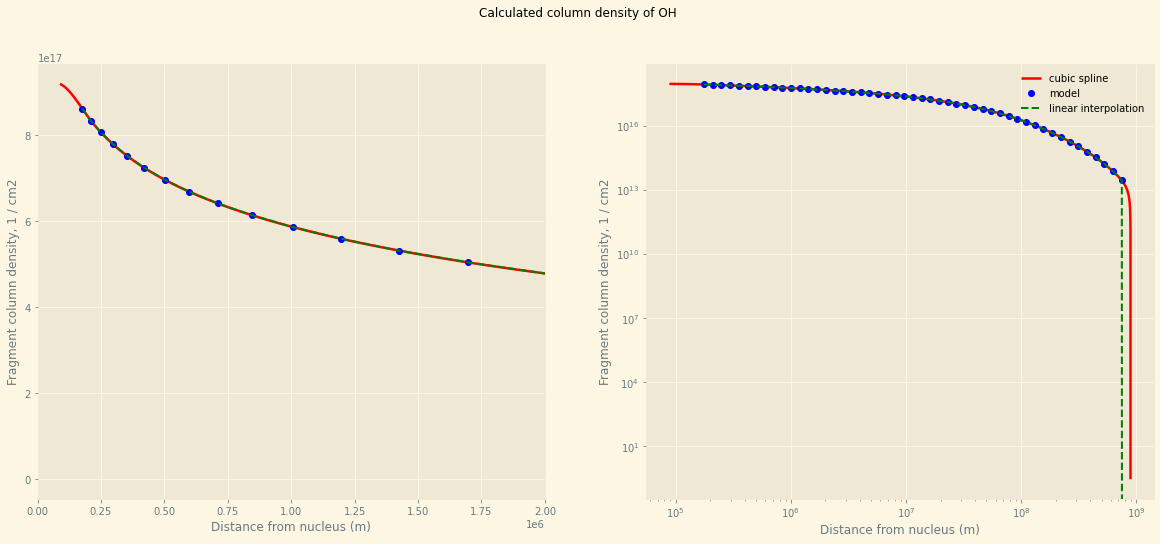

In [5]:
fragName = 'OH'
cdUnits = 1/(u.cm**2)
xMin_logplot = coma.vModel['CollisionSphereRadius'].to('m').value
xMax_logplot = coma.vModel['MaxRadiusOfGrid'].to('m').value

xMin_linear = 0
xMax_linear = 2000000

interpArrayX = np.linspace(xMin_logplot, xMax_logplot, 100000)
interpArrayY = coma.vModel['ColumnDensity']['Interpolator'](interpArrayX)

plt.style.use('Solarize_Light2')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.set(xlabel='Distance from nucleus (m)')
ax1.set(ylabel=f"Fragment column density, {cdUnits.unit.to_string()}")
ax2.set(xlabel='Distance from nucleus (m)')
ax2.set(ylabel=f"Fragment column density, {cdUnits.unit.to_string()}")
fig.suptitle(f"Calculated column density of {fragName}")

ax1.set_xlim([xMin_linear, xMax_linear])
ax1.plot(interpArrayX, interpArrayY, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
ax1.plot(coma.vModel['ColumnDensity']['CDGrid'], coma.vModel['ColumnDensity']['Values'], 'bo', label="model")
ax1.plot(coma.vModel['ColumnDensity']['CDGrid'], coma.vModel['ColumnDensity']['Values'], 'g--', label="linear interpolation")

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.loglog(interpArrayX, interpArrayY, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
ax2.loglog(coma.vModel['ColumnDensity']['CDGrid'], coma.vModel['ColumnDensity']['Values'], 'bo', label="model")
ax2.loglog(coma.vModel['ColumnDensity']['CDGrid'], coma.vModel['ColumnDensity']['Values'], 'g--', label="linear interpolation")

plt.legend(loc='upper right', frameon=False)
plt.show()

Note that the volume density is only tracked out to a certain radius, which can cause the column density at the edge of the coma to behave strangely if there is a significant amount of fragments near the edge of the model's grid.

### Examining the results for column density by printing out the model's grid data

In [6]:
print("\nRadius (km) vs Column density (1/cm2)\n-------------------------------------")
cds = list(zip(coma.vModel['ColumnDensity']['CDGrid'], coma.vModel['ColumnDensity']['Values']))
for pair in cds:
    print(f'{pair[0].to(u.km):7.0f} :\t{pair[1].to(1/(u.cm**2)):5.3e}')


Radius (km) vs Column density (1/cm2)
-------------------------------------
    176 km :	8.619e+13 1 / cm2
    210 km :	8.342e+13 1 / cm2
    250 km :	8.067e+13 1 / cm2
    297 km :	7.792e+13 1 / cm2
    354 km :	7.517e+13 1 / cm2
    421 km :	7.242e+13 1 / cm2
    501 km :	6.967e+13 1 / cm2
    597 km :	6.692e+13 1 / cm2
    710 km :	6.417e+13 1 / cm2
    845 km :	6.142e+13 1 / cm2
   1006 km :	5.868e+13 1 / cm2
   1197 km :	5.593e+13 1 / cm2
   1424 km :	5.320e+13 1 / cm2
   1695 km :	5.046e+13 1 / cm2
   2017 km :	4.774e+13 1 / cm2
   2401 km :	4.503e+13 1 / cm2
   2857 km :	4.232e+13 1 / cm2
   3400 km :	3.964e+13 1 / cm2
   4047 km :	3.698e+13 1 / cm2
   4816 km :	3.434e+13 1 / cm2
   5731 km :	3.173e+13 1 / cm2
   6821 km :	2.916e+13 1 / cm2
   8118 km :	2.663e+13 1 / cm2
   9661 km :	2.416e+13 1 / cm2
  11497 km :	2.174e+13 1 / cm2
  13682 km :	1.940e+13 1 / cm2
  16283 km :	1.715e+13 1 / cm2
  19379 km :	1.499e+13 1 / cm2
  23062 km :	1.295e+13 1 / cm2
  27446 km :	1.103e+13 1

### 3D plot of the interpolated column density

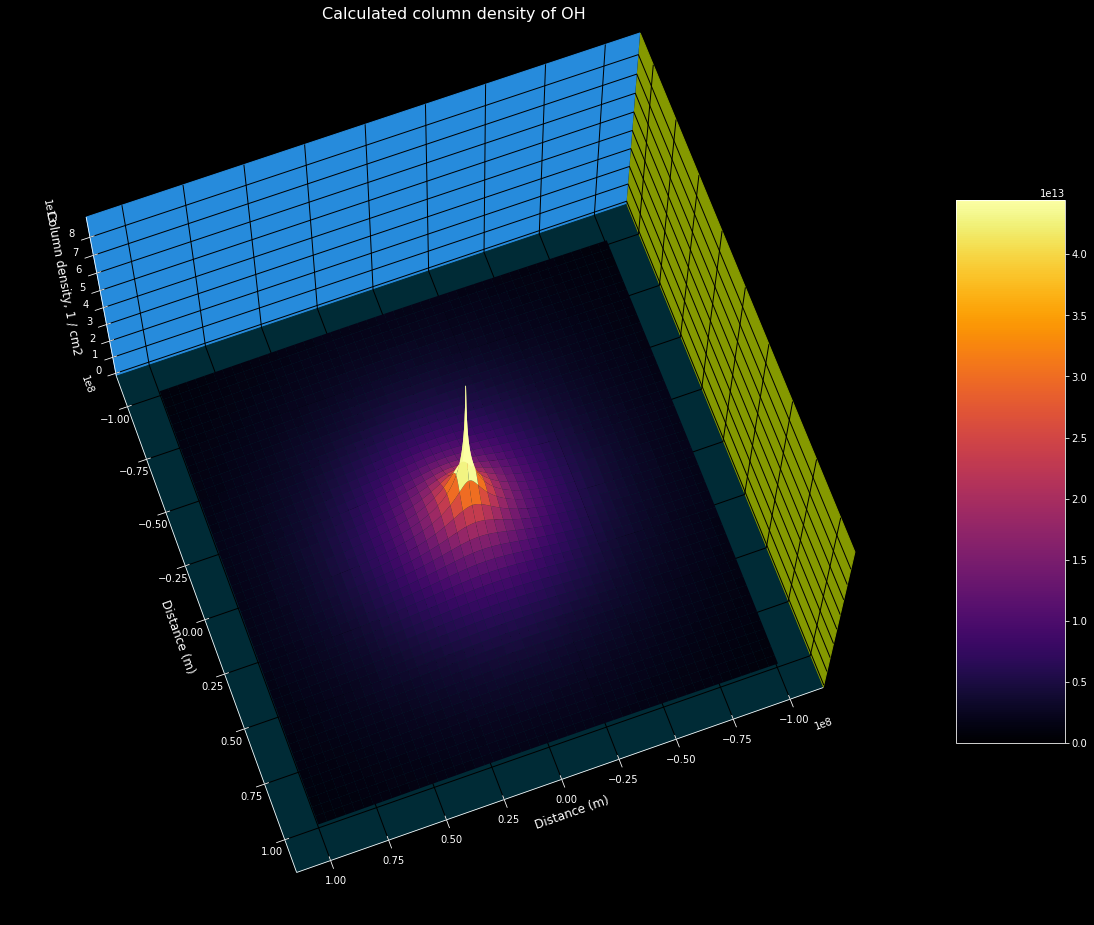

In [7]:
solarbluecol = np.array([38, 139, 220]) / 255.
solarblue = (solarbluecol[0], solarbluecol[1], solarbluecol[2], 1)
solargreencol = np.array([133, 153, 0]) / 255.
solargreen = (solargreencol[0], solargreencol[1], solargreencol[2], 1)
solarblackcol = np.array([0, 43, 54]) / 255.
solarblack = (solarblackcol[0], solarblackcol[1], solarblackcol[2], 1)

x = np.linspace(-100000000, 100000000, 1000)
y = np.linspace(-100000000, 100000000, 1000)
xv, yv = np.meshgrid(x, y)
z = coma.vModel['ColumnDensity']['Interpolator'](np.sqrt(xv**2 + yv**2))
# Interpolator spits out m^-2
fz = (z/u.m**2).to(cdUnits)

plt.style.use('Solarize_Light2')
plt.style.use('dark_background')
plt.rcParams['grid.color'] = "black"

fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, fz, cmap='inferno', vmin=0, edgecolor='none')

plt.gca().set_zlim(bottom=0)

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Distance (m)')
ax.set_zlabel(f"Column density, {cdUnits.unit.to_string()}")
plt.title(f"Calculated column density of {fragName}")

ax.w_xaxis.set_pane_color(solargreen)
ax.w_yaxis.set_pane_color(solarblue)
ax.w_zaxis.set_pane_color(solarblack)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(70, 70)
plt.show()

### Theoretical fragment count vs. count obtained by integration of the calculated volume density

In [8]:
fragments_theory = coma.vModel['NumFragmentsTheory']
fragments_grid = coma.vModel['NumFragmentsFromGrid']
print("\nTheoretical total number of fragments in coma: ", fragments_theory)
print("Total number of fragments from density grid integration: ", fragments_grid)
print(f"Percentage of fragments: {fragments_grid/fragments_theory}")


Theoretical total number of fragments in coma:  3.071995870359043e+33
Total number of fragments from density grid integration:  3.0119080287242207e+33
Percentage of fragments: 0.980440129423807


### Obtaining total counts of fragments within apertures

In [9]:
# Set aperture to entire comet to see if we get all of the fragments as an answer
ap1 = sba.RectangularAperture((coma.vModel['MaxRadiusOfGrid'].value, coma.vModel['MaxRadiusOfGrid'].value) * u.m)
print("Percent of total fragments recovered by integrating column density over")
print("\tLarge rectangular aperture: ", coma.total_number(ap1)/fragments_theory)

# One more time
ap2 = sba.CircularAperture((coma.vModel['MaxRadiusOfGrid'].value) * u.m)
print("\tLarge circular aperture: ", coma.total_number(ap2)/fragments_theory)

# Try out annular
ap3 = sba.AnnularAperture([500000000, coma.vModel['MaxRadiusOfGrid'].value]*u.m)
print("\tAnnular aperture, inner radius 500000 km, outer radius of entire grid:\n\t",
      coma.total_number(ap3)/fragments_theory)

Percent of total fragments recovered by integrating column density over
	Large rectangular aperture:  0.9489720916415337
	Large circular aperture:  0.9800984195356757
	Annular aperture, inner radius 500000 km, outer radius of entire grid:
	 0.02948032527751073


Despite the severe falloff of the column density above, the two large apertures still recover most of the fragments, but the difference in integration methods result in a notable difference in the amounts.
The model's data is stored as a function of radial distance from the nucleus, so the circular aperture is generally more trustworthy with its results.

### Optional parameters to the model

The following can be passed to VectorialModel to tweak its behavior:

radial_points (int): Number of grid points to use for the radial density grids, both volume and column density

radial_substeps (int): Controls how much each grid point will slice up the density-contributing sections of the coma

angular_points (int): Number of angular slices to take around the coma

angular_substeps (int): Controls the angular slicing of the density-contributing sections of the coma

parent_destruction_level (float): Percentage of parent molecules that will be destroyed before the grid gets cut off

fragment_destruction_level (float): Similar but for fragments

max_fragment_lifetimes (float): If a fragment has to travel farther than this many lifetimes to contribute to the density at another point in the coma, we ignore it entirely

print_progess (bool): This will periodically print out progress while calculating fragment density